In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/gdrive/MyDrive/Kaggle"

In [ ]:
%cd "/gdrive/MyDrive/Kaggle"

/gdrive/MyDrive/Kaggle


In [ ]:
!kaggle competitions download -c pku-autonomous-driving

pku-autonomous-driving.zip: Skipping, found more recently modified local copy (use --force to force download)


Let us load and analyse the data

Import Modules

In [ ]:
import numpy as np
import pandas as pd
import cv2
import json
import os
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
Input = '/gdrive/MyDrive/Kaggle'
file_list = os.listdir(Input)
print(file_list)

['sample_submission.csv', 'train.csv', 'kaggle.json', 'sample_submission (1).csv', 'v99ap2_n', 'v99ap3_n', 'camera', 'car_models', 'car_models_json', 'test_images', 'test_masks', 'train_images', 'train_masks', 'test', 'autonomous-driving-checkpoint.zip', 'pku-autonomous-driving.zip', 'myenv', 'my_output_directory', 'autonomous-driving-1st-place-solution-inference.ipynb', 'inputt']


List File folders

In [ ]:
Input = '/gdrive/MyDrive/Kaggle'
file_list = os.listdir(Input)

selected = ['train_masks', 'train.csv', 'sample_submission.csv', 'test_images', 'test_masks', 'camera', 'car_models', 'car_models_json', 'train_images']

input = [folder for folder in file_list if folder in selected]
print(input)


['sample_submission.csv', 'train.csv', 'camera', 'car_models', 'car_models_json', 'test_images', 'test_masks', 'train_images', 'train_masks']


Load Train Dataset

In [ ]:
Input = '/gdrive/MyDrive/Kaggle/'
train_csv_path = os.path.join(Input, 'train.csv')
train = pd.read_csv(train_csv_path)
train.head()


ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

What is Prediction String?

As per the data: The primary data is images of cars and related pose information. The pose information is formatted as strings, as follows: model type, yaw, pitch, roll, x, y, z

In [ ]:
print('Annotations for Image ',train['ImageId'][0],' are ',train['PredictionString'][0])

Annotations for Image  ID_8a6e65317  are  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323


How many cars are there in Image ID_8a6e65317?

In [ ]:
annotations = train['PredictionString'][0].split(' ')
print(len(annotations) / 7)

5.0


Annotations for cars

Seperate the list of annotations to each car's pose

In [ ]:
poses = []

for index in range(0,int(len(annotations)/7)):
    i = index*7
    poses.append(annotations[i:i+7])

In [ ]:
print(poses)

[['16', '0.254839', '-2.57534', '-3.10256', '7.96539', '3.20066', '11.0225'], ['56', '0.181647', '-1.46947', '-3.12159', '9.60332', '4.66632', '19.339'], ['70', '0.163072', '-1.56865', '-3.11754', '10.39', '11.2219', '59.7825'], ['70', '0.141942', '-3.1395', '3.11969', '-9.59236', '5.13662', '24.7337'], ['46', '0.163068', '-2.08578', '-3.11754', '9.83335', '13.2689', '72.9323']]


Visualise the x,y annotations on Image ID_8a6e65317

2D Visualisation

The points are in World Coordinates. They have to be converted to camera coordinate for visualisation

Conversion to camera coordinate

In [ ]:
#Read camera parameters 
fx = 2304.5479
fy = 2305.8757
cx = 1686.2379
cy = 1354.9849
camera_matrix = np.array([[fx, 0,  cx],
           [0, fy, cy],
           [0, 0, 1]], dtype=np.float32)

In [ ]:
def convert2camera(worldCoord):
    x,y,z = worldCoord[0],worldCoord[1],worldCoord[2]
    return x * fx / z + cx, y * fy / z + cy

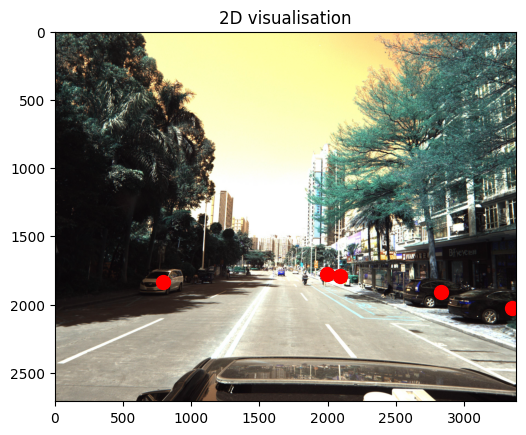

In [ ]:
# Plot inline
%matplotlib inline

x = []
y = []
img = cv2.imread(Input+'train_images/ID_8a6e65317.jpg')

for item in poses:
    coord = (float(item[4]),float(item[5]),float(item[6]))
    x.append(convert2camera(coord)[0])
    y.append(convert2camera(coord)[1])
   
plt.scatter(x,y, color='red', s=100);


plt.imshow(img)
plt.title('2D visualisation')
plt.show()

3D Visualisation

In [ ]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [ ]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
    return image

In [ ]:
def visualize(img, coords):
    #Just the mean value of all type of car's dimension 
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = float(point[4]), float(point[5]), float(point[6])
        yaw, pitch, roll = -float(point[1]), -float(point[2]), -float(point[3])
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

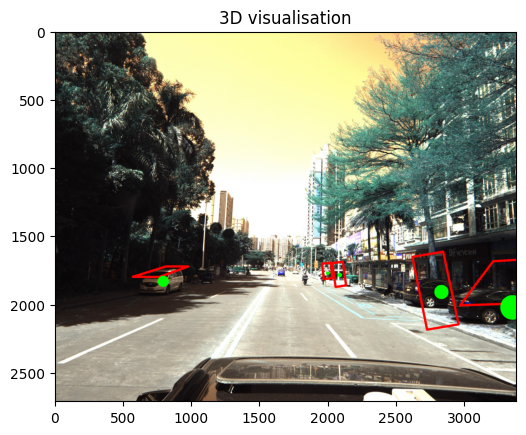

In [ ]:
img = cv2.imread(Input+'train_images/ID_8a6e65317.jpg')

bbox = visualize(img,poses)

plt.imshow(bbox)
plt.title('3D visualisation')
plt.show()

3D car model json files

How many models do we have?

In [ ]:
json_files = os.listdir(Input+'car_models_json')
print(len(json_files))

79


Lets examine one mode

In [ ]:
#Load the model
with open(Input+'car_models_json/fengtian-SUV-gai.json') as json_file:
    car_model_data = json.load(json_file)

The File contains the car type, vertices and faces.

In [ ]:
for keys in enumerate(car_model_data):
    print(keys)

(0, 'car_type')
(1, 'vertices')
(2, 'faces')


Plot the 3D model

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def plot_3d_car(model_json_file):
    with open(Input+f'car_models_json/{model_json_file}') as json_file:
        car_model_data = json.load(json_file)

    vertices = np.array(car_model_data['vertices'])
    faces = np.array(car_model_data['faces']) - 1
    car_type = car_model_data['car_type']
    x, y, z = vertices[:,0], vertices[:,2], -vertices[:,1]
    fig = plt.figure(figsize=(30, 10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(x, y, faces, z,
                    cmap='viridis', edgecolor='none')
    ax.set_title(car_type)
    ax.view_init(30, 0)
    plt.show()
    fig = plt.figure(figsize=(30, 10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(x, y, faces, z,
                    cmap='viridis', edgecolor='none')
    ax.set_title(car_type)
    ax.view_init(60, 0)
    plt.show()
    fig = plt.figure(figsize=(30, 10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(x, y, faces, z,
                    cmap='viridis', edgecolor='none')
    ax.set_title(car_type)
    ax.view_init(-20, 180)
    plt.show()
    return

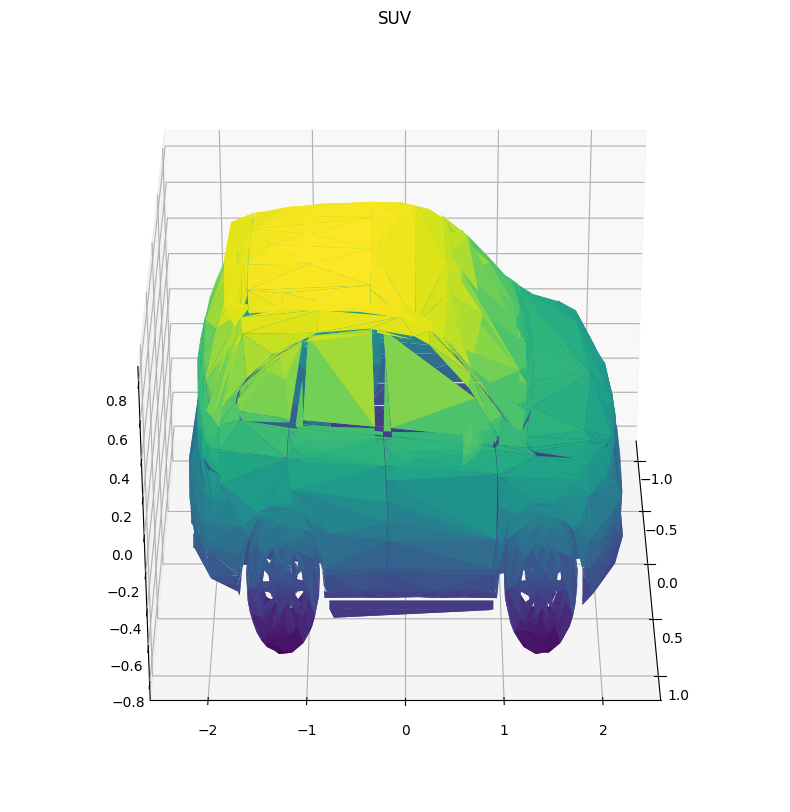

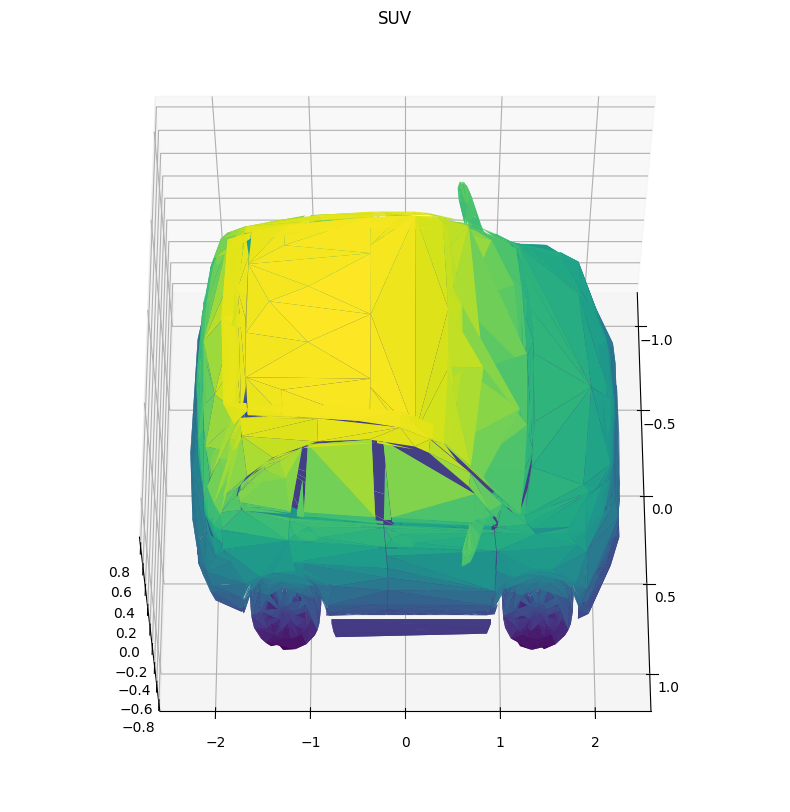

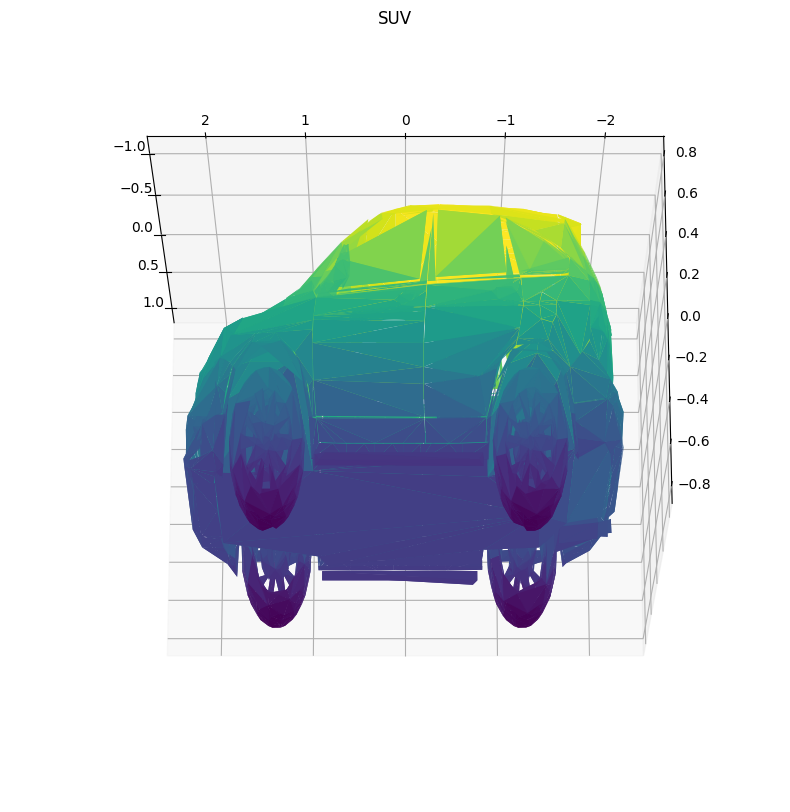

In [ ]:
plot_3d_car('fengtian-SUV-gai.json')

Masks

From Documentation :
Some cars in the images are not of interest (too far away, etc.). Binary masks are provided to allow competitors to remove them from consideration.


Load the masks

In [ ]:
mask_files = os.listdir(Input+'train_masks')
print('Number of mask images : ',len(mask_files))
train_images = os.listdir(Input+'train_images')
print('Number of train images : ',len(train_images))

Number of mask images :  4010
Number of train images :  4262


There are different number of masks and images

Read mask image

In [ ]:
mask = cv2.imread(Input+'train_masks/ID_8a6e65317.jpg')
image = cv2.imread(Input+'train_images/ID_8a6e65317.jpg')


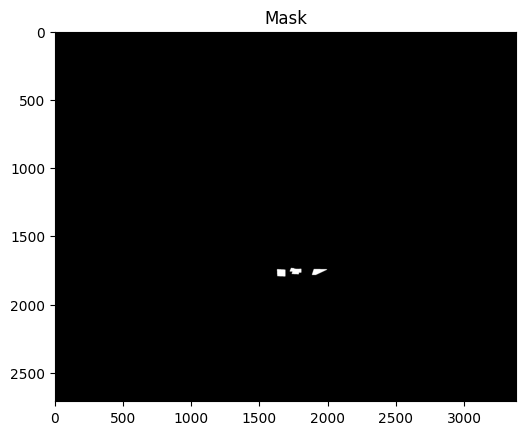

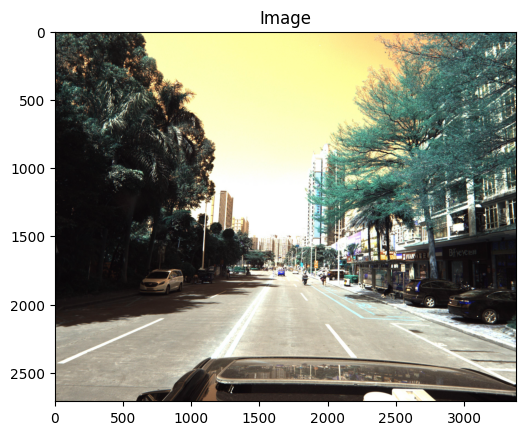

In [ ]:
plt.imshow(mask)
plt.title('Mask')
plt.show()

plt.imshow(image)
plt.title('Image')
plt.show()

Which cars are out of scope?

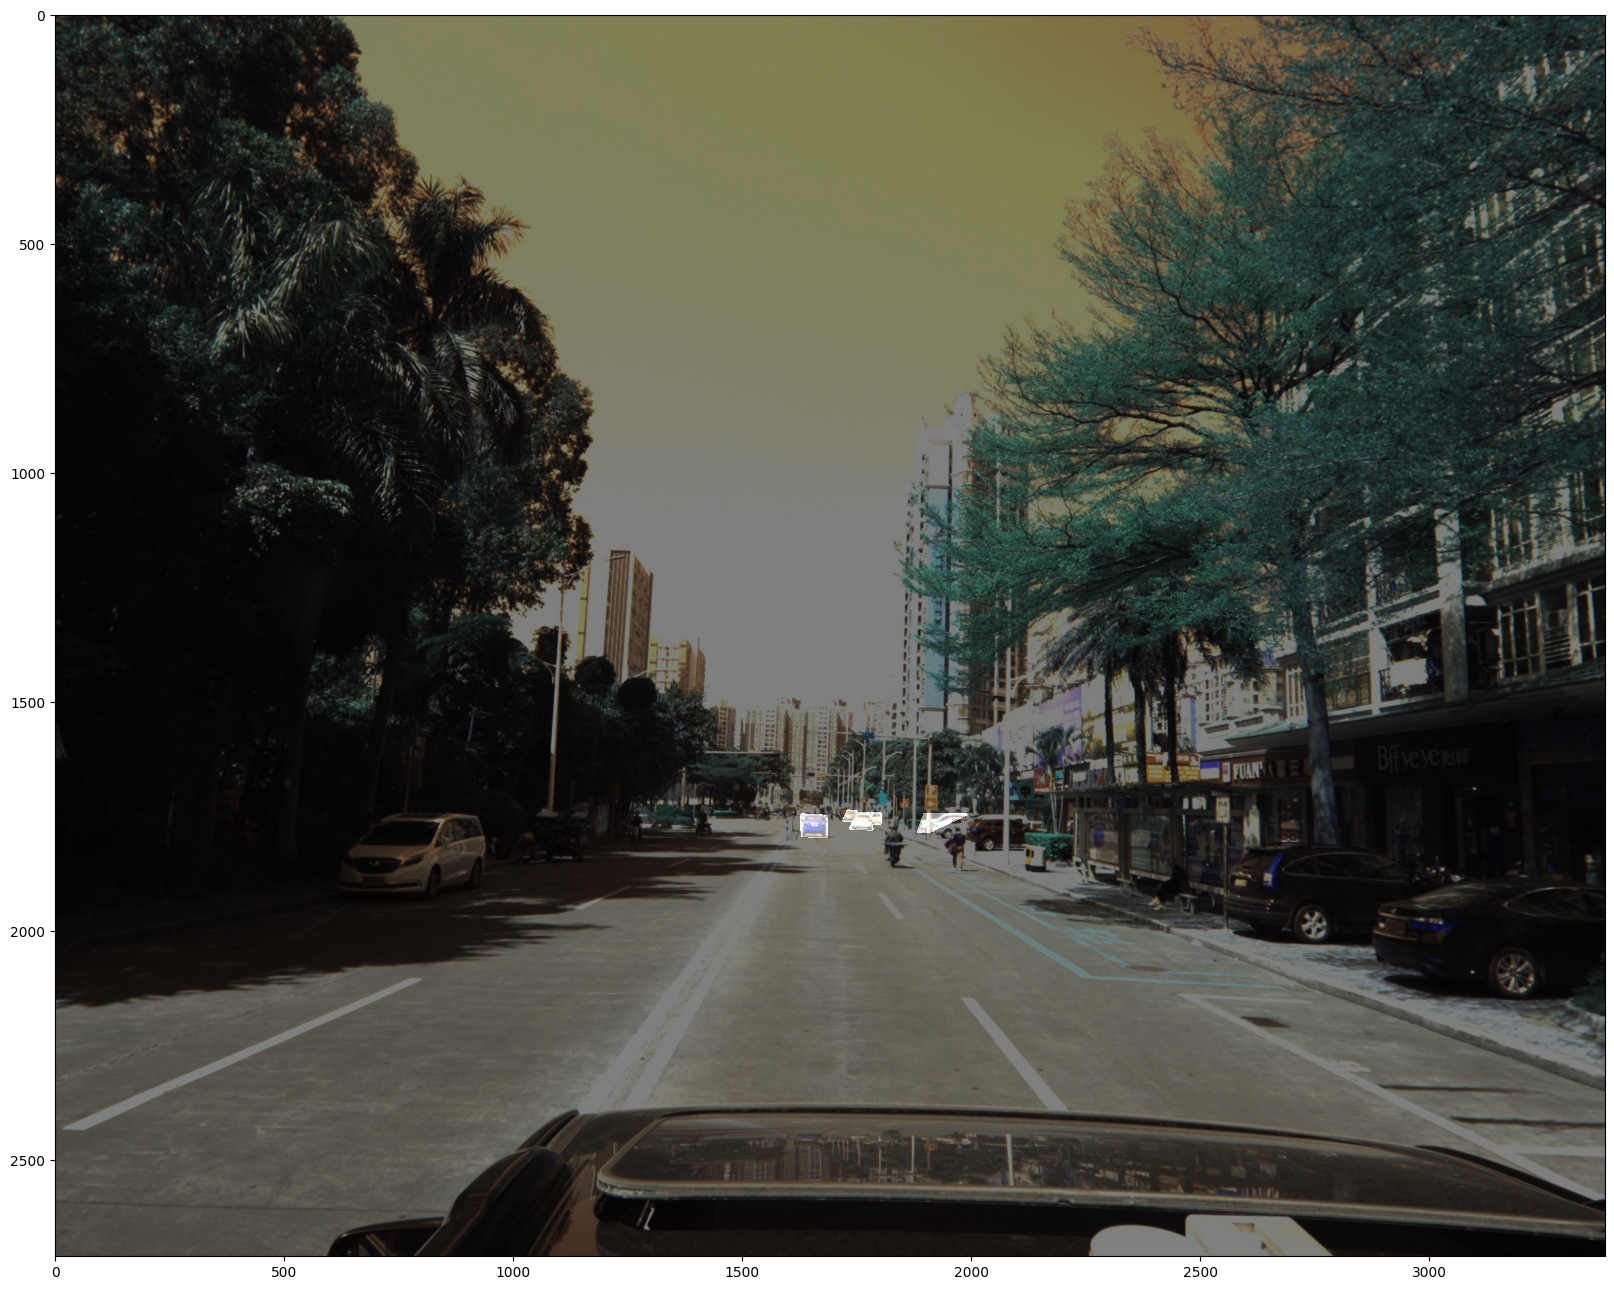

In [ ]:
fig, ax = plt.subplots(figsize=(20, 25))
plt.imshow(image)
plt.imshow(mask, cmap=plt.cm.viridis, interpolation='none', alpha=0.5)
plt.show()

The cars shown inside white boxes are out of scope